## 前言
AI多模态大模型发展至今，每年都有非常优秀的工作产出，按照当前模型设计思路，多模态大模型的架构主要包括以下几个部分：
1. 模态编码器(Modality Encoer,ME): 负责将不同模态的输入编码成特征。常见的编码器包括图像的NFNet-F6,ViT, CLIP ViT等，音频的Whisper,CLAP等，视频编码器等

2. 输入投影器(Input Projector, IP): 负责将其他模态的特征脱颖到文本特征空间，并与文本特征一起输入给语言模型。 常用的投影器包括线性投影器，MLP,Cross Attention 交叉注意力等。

3. 语言模型骨架(LLM Backbone): 利用预训练的语言模型，负责处理各种模态的特征，进行语义理解，推理和决策。 常用的语言模型包括Flan-T5, ChatGLM,UL2,Llama等。

4. 输出投影器(Output Projector, OP): 负责将语言模型输出的信号转换成其他模态的特征，以供后续模态生成器使用。 常用的投影器包括Tiny Transformer, MLP等

    什么是 Output Projector（OP）？
    - 在 多模态生成系统 中（Text → Image / Audio / Video / Action）：
        LLM hidden states
                ↓
        Output Projector (OP)
                ↓
        Modality-specific Generator
        (图像 / 音频 / 视频 / 动作)

    - OP 的核心作用是：
        将 语言空间（token-level / sequence-level）
        映射到 目标模态的潜在空间（latent / conditioning space）

        它本质上是一个 跨模态对齐模块（cross-modal adapter）。

    见 Output Projector 类型（重点）

    1️⃣ 线性投影（Linear Projection / MLP）

    最基础、最常用

    形式：
    Z_{modal} = W \cdot H_{LLM} + b

    或多层：
    Z = \text{MLP}(H_{LLM})

    特点
        •	参数少
        •	易训练
        •	稳定
        •	工程首选

    使用场景
        •	Text → Diffusion (UNet condition)
        •	Text → Audio latent
        •	Text → Video token

    代表工作
        •	Stable Diffusion text encoder → UNet cross-attn
        •	AudioLDM conditioning
        •	Video diffusion models

    ✅ 工业界最常见

    ⸻

    2️⃣ Query-based 投影（Q-Former / Query Transformer）

    核心思想
        •	使用一组 learnable queries
        •	从 LLM hidden states 中“抽取”对生成最有用的信息
            Learnable Queries
                ↓ cross-attn
            LLM hidden states
    特点
        •	可压缩长文本
        •	对齐能力强
        •	适合 token → latent 映射

    代表
        •	BLIP-2 / BLIP-3
        •	Flamingo
        •	Video-LLaMA

    优点
        •	解耦 LLM 与生成器
        •	Token 数可控

    缺点
        •	结构复杂
        •	训练成本高

    ⸻

    3️⃣ Cross-Attention 投影（Cross-Modal Attention）

    形式
        •	LLM 输出作为 Key / Value
        •	目标模态 latent 作为 Query

    \text{Attn}(Q_{modal}, K_{text}, V_{text})

    特点
        •	动态条件注入
        •	高表达能力

    应用
        •	Diffusion UNet cross-attn
        •	Video Transformer conditioning
        •	Audio generation conditioning

    本质

    OP = 一个 cross-attention block

    ⸻

    4️⃣ Adapter-based 投影（Adapter / LoRA-style）

    思想
        •	在 LLM 输出后插入一个 轻量适配器
        •	冻结 LLM 主干

    结构
        H_LLM → Adapter → Z_modal

    特点
        •	参数效率高
        •	适合多任务 / 多模态扩展

    应用
        •	多模态 LoRA
        •	Edge / on-device models
        •	TV / IoT 场景（你很熟）

    ⸻

    5️⃣ Token Resampler / Pooling 投影

    做什么
        •	把 N 个 token → M 个 token
        •	常见方法：
        •	Mean Pooling
        •	Attention Pooling
        •	Perceiver Resampler

    典型结构
        •	Perceiver IO
        •	Flamingo Resampler

    适合
        •	文本很长
        •	生成器 token budget 固定

    ⸻

    6️⃣ 结构化输出投影（Structured OP）

    不是直接生成 latent，而是中间结构

    例子：
        •	Scene graph
        •	Action plan
        •	Music score
        •	Control tokens

    流程
        LLM → structured tokens → generator

    应用
        •	Robotics / Embodied AI
        •	Video planning
        •	Game agents

    ⸻

    三、不同模态常用 OP 对照表
        目标模态                    常用 OP
        图像（Diffusion）           Linear / MLP + Cross-Attn
        音频（TTS / Music）         MLP / Attention
        视频                       Q-Former / Resampler
        动作 / 控制                 Structured OP
        多模态统一                  Adapter + Attention

    常用的投影器包括：线性投影（Linear/MLP）、基于查询的投影器（如 Q-Former）、跨注意力投影（Cross-Attention）、轻量级适配器（Adapter/LoRA），以及用于 token 压缩的重采样投影器（Resampler）。

    1️⃣ MLP / Linear（90% 场景）
    2️⃣ Cross-Attention（Diffusion）
    3️⃣ Q-Former（复杂 multimodal）
    4️⃣ Structured OP（规划 / 控制）

5. 模态生成器(Modality Generator, MG): 负责生成其他模态的输出。常用的生成器包括图像的stable Diffusion, 视频的Zeroscope, 音频的AudioLDM等。

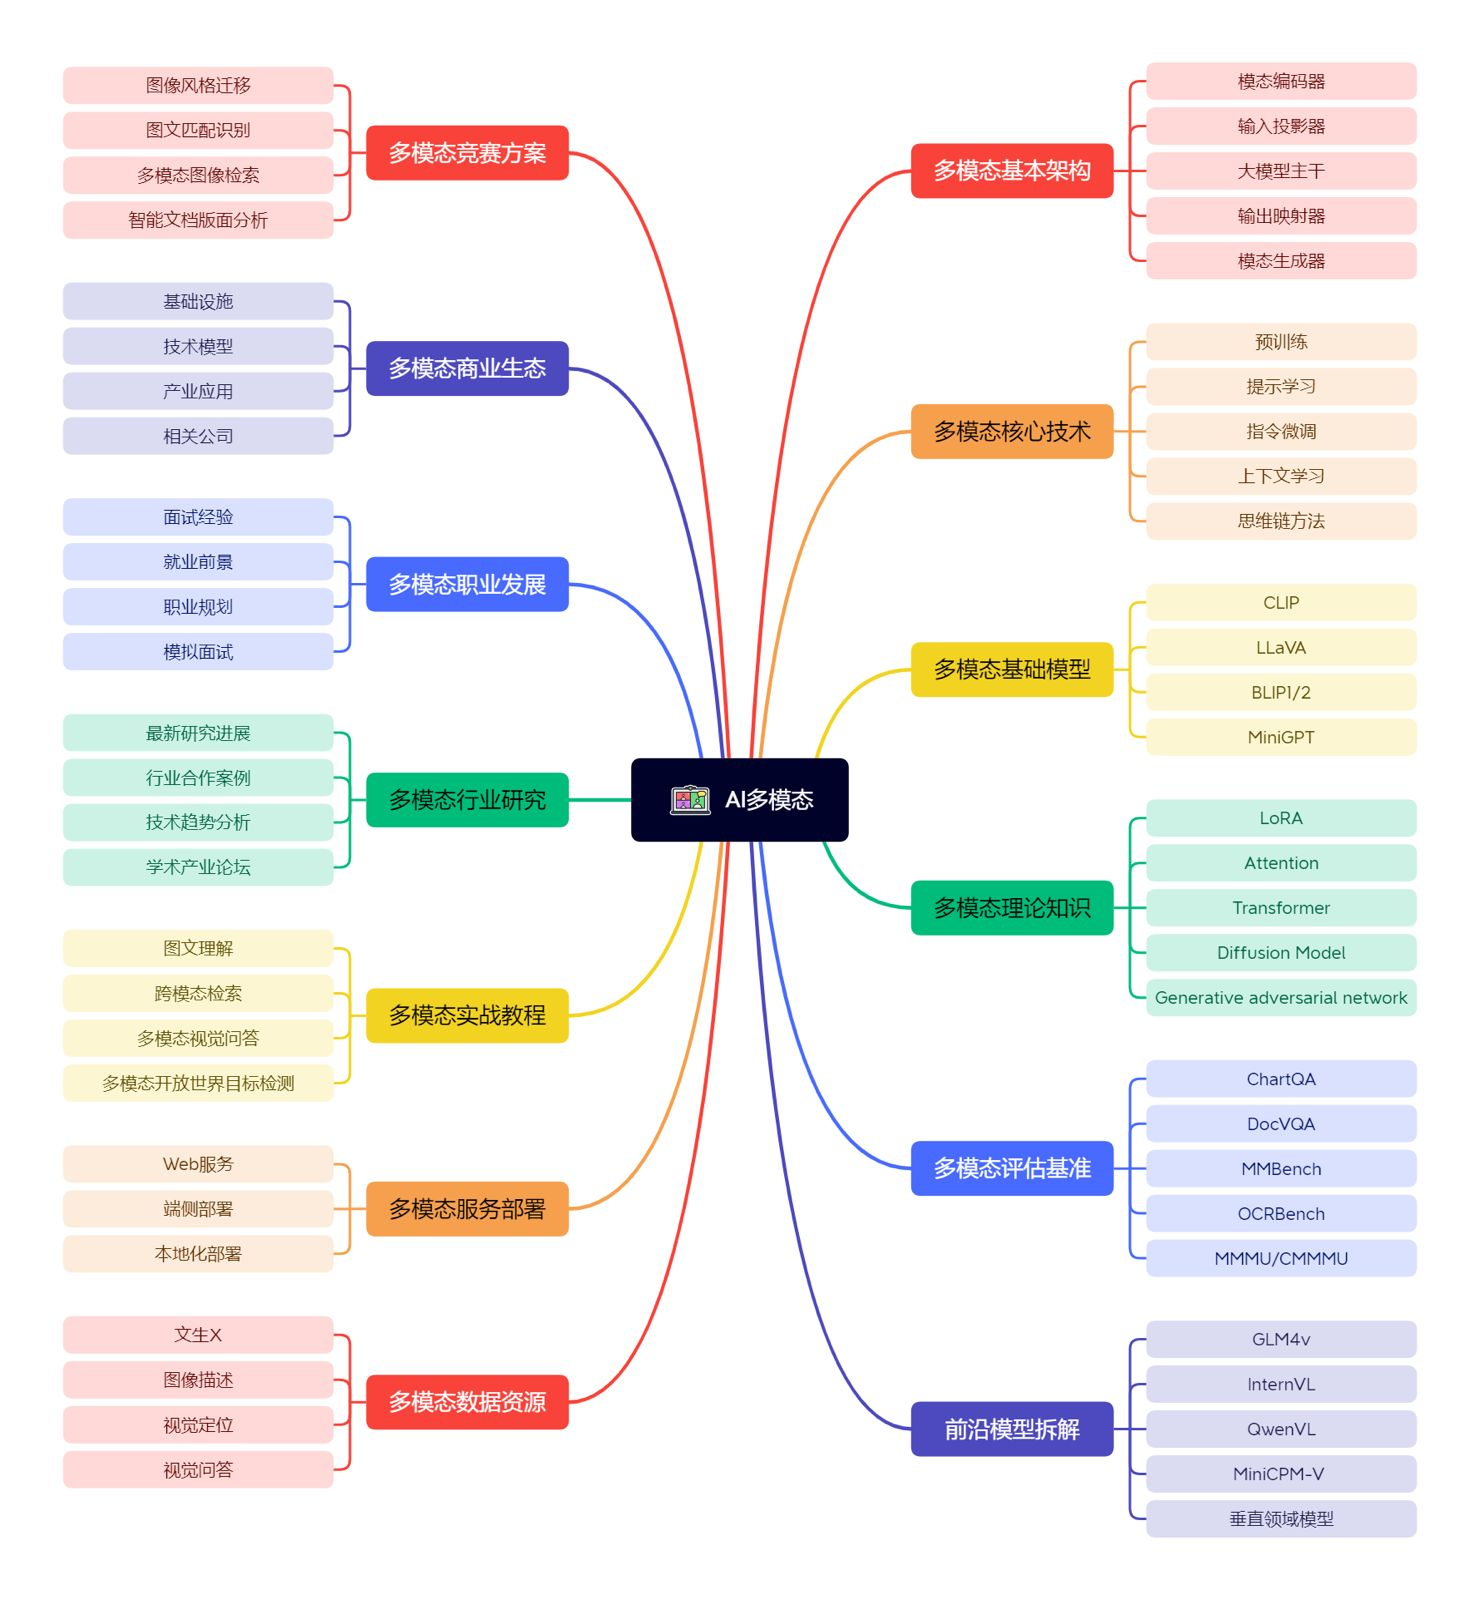

## 在多模态大型语言模型(MM-LLMs)中，模态编码器(Modality Encoder, ME)负责将来自不同模态的输入转换为模型可以理解的特征表示。以下是各种模态编码器的详细介绍：

一、图像编码器
    图像编码器是用于处理视觉信息的组件，它将图像数据转换成一种可以被模型进一步分析的格式。这通常涉及到特征提取，即从图像中提取有用的信息，如颜色，纹理，形状和对象位置等。
1.1 NFNet
    NFNet（Normalizer-Free ResNets）是DeepMind提出了一种不需要Batch Normalization的基于ResNet的网络结构，其核心为一种AGC（adaptive gradient clipping technique，自适应梯度裁剪）技术。最小的NFNet版本达到了EfficientNet-B7的准确率，并且训练速度快了8.7倍，最大版本的模型实现了新的SOTA效果。

下图展示了NFNet模型结构图：
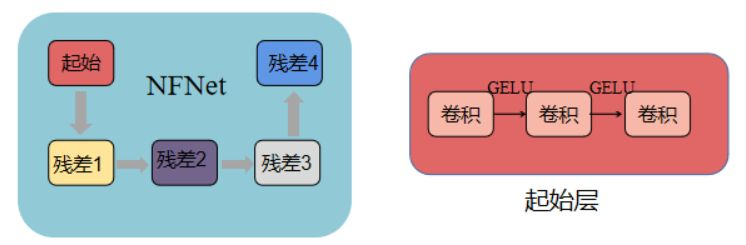

    NFNet模型的初始主干部分，也称为模型的起始层，是构建整个网络结构的基础。这部分包括一系列卷积层，旨在从输入图像中提取初级特征。首先，模型采用一个3x3的卷积核，步长为2，这有助于在减少图像尺寸的同时，提取出基础的特征。该层的通道数设定为16，这表示它能处理16个不同的特征图，从而捕捉到丰富的图像信息。

    紧接着，模型进一步通过两个3x3的卷积层，步长均为1，来深化特征提取。这些层的通道数分别为32和64，逐步增加通道数有助于网络学习更复杂的特征。这种设计策略不仅增加了网络的深度，也增加了其宽度，从而提高了特征的丰富性和多样性。

    在上述卷积层之后，模型采用了一个3x3的卷积层，其步长为2，通道数为128。这一层在进一步减少图像尺寸的同时，通过增加通道数，聚合了更高级别的特征。这样的设计有助于网络在保持计算效率的同时，提取到更抽象的图像特征。

    值得注意的是，每个卷积层之间都嵌入了一个非线性的激活函数GELU。GELU（高斯误差线性单元）是一种轻量的激活函数，它能够有效地改善深度学习模型的性能，特别是在处理复杂和抽象的特征时。通过在每个卷积层后应用GELU，模型能够更好地捕捉和传递特征之间的非线性关系。

    在初始主干之后，模型进入了4个残差阶段。这些阶段是模型的核心，负责进一步提取和传递图像特征。每个阶段从过渡块开始，然后是标准残差块。过渡块在除了第一阶段的所有阶段中执行下采样，这有助于减少特征图的尺寸，同时增加其深度。在下采样路径中，2x2的平均池化层被用来减少空间维度，而第一个3x3卷积层则负责改变输出通道数，以适应网络深度的增加。

    在起始块之后，模型经过4个不同的残差块，每个块都由一系列卷积层和激活函数组成。这些残差块的设计旨在通过跳跃连接来允许梯度直接流过这些块，从而有效地解决了深层网络训练中的梯度消失问题。通过这种方式，模型能够从输入图像中提取出丰富的特征，这些特征将在后续的网络层中被进一步处理和分析，最终实现对图像内容的理解和分类。

    怎么理解自适应梯度裁剪技术？

    自适应梯度裁剪（AGC）是一种用于稳定深度学习模型训练的技术，特别是在不使用批归一化（Batch Normalization，简称BN）的情况下。在深度学习中，梯度裁剪是一种常用的技术，用于防止梯度爆炸问题，即当梯度更新非常大时，可能导致模型权重更新过于激进，从而使训练过程不稳定。

    AGC的核心思想是动态调整梯度的幅度，使其与模型权重的大小成比例。具体来说，AGC会监控每个权重参数的梯度范数（即梯度向量的长度）和权重参数本身的范数，然后根据一个预设的阈值来裁剪梯度。如果梯度的范数超过了这个阈值，AGC会按比例减小梯度，以保持梯度更新在一个合理的范围内。

    在NFNet中，AGC的使用使得模型能够在没有BN的情况下，通过大批量训练和强数据增强来达到高性能。这是因为BN层在传统模型中提供了一种隐式的正则化效果和梯度范数的稳定化，而AGC在没有BN的情况下提供了类似的稳定性。

1.2 ViT
    ViT(Visiontransformer)是 Google 在2020年提出的直接将 Transformer 应用在图像分类的模型。Vit 对图像处理的方法很简单：先把图像分割成大小一样的小块(patches)，然后通过线性变换获得 patch embeddings。由于 Transformer 的输入是词向量组合，因此将图像的 patch embeddings 嵌入 Transformer 后，它可以提取特征并进行分类。

Vit 模型的工作原理，如下图所示，其中Vit 模型只使用Transformer的编码器Encoder 部分来提取并解析特征。
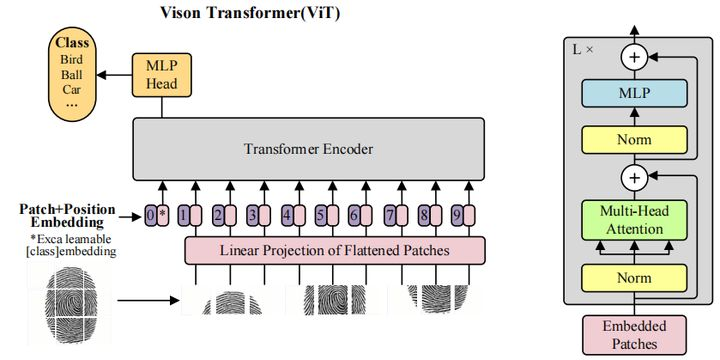
    按照上面的流程图，一个 Vit模块可以分为以下几个步骤:
    (1) 分割块嵌入. 假设经过预处理后的输入图片大小为 224x224，共有3通道。首先将图像分割成大小为 16x16 的分割块(patches)，一共有 196 个分割块，这时我们将图片变换成为一个长度为 196 的序列，即一共有 196个 token。这些分割块通过线性变换展平成列向量，将 16x16x3 的分割块展平成 768 维的列向量，此时的 token 序列维度为 196x768。此外我们还需要加上一个专门用来分类的 class token，将其与 token序列进行拼接得到 197x768 的向量。

    (2) 位置编码. 和 Transformer 一样，Vision Transformer 同样需要加入位置编码。位置编码可以看做一个表格，对于一个长度为 196 的序列，同样需要一个行数为 196 的位置编码，每一行位置编码的维度与每一个 token 的维度一样，均为 768 维。加入位置编码的方法是，每一行位置编码与序列中的每一个 token 对应相加，得到的新向量维度仍然为 197x768。

    (3) 输入到Transformer Encoder。Transformer Encoder 就是重复堆叠 Encoder Block N 次，主要由以下几部分组成:
    - Layer Norm，这是一种专门针对 NP 领域的归一化方法,这里对 197 个 token进行归一化处理。

    - 多头自注意力，先将输入的 197x768 维 token序列进行分头处理，假设共有12 个头(768/12=64),那么映射到每一个 q、k、v 的维度为 197x64，一共有 12 组 q、k、v最后再将 12 组 qkv 的输出拼接起来，维度为 197x768。

    - 最后经过一层 Dropout 正则化，完成一次编码过程。

    (4) 分类器(MLP Head)。 经过 Transformer Encoder 后的 token 的维数仍然为 197x768。此时需要 MLP Head 进行分类，这时只需要提取出 class token 并生成对应的分类结果即可，这里 class token 为 1X768 维。最后通过 MLP Head 得到我们最终的分类结果，MLP Head 由两个全连接层，一个 tanh 激活函数所组成。
下面的动图演示了VIT的数据输入到输出的流程：
    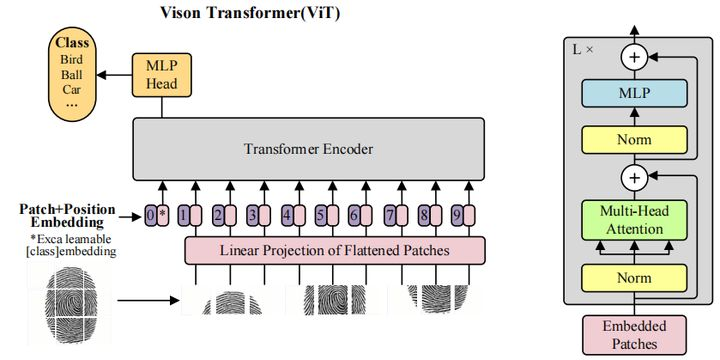

1.3 CLIP VIT是在大名鼎鼎的CLIP这项工作中，作者团队使用约4亿个图像-文本对数据训练得到的VIT权重，可以说是当前最强的VIT模型之一，Clip VIT已经成为目前多数多模态模型的首选：
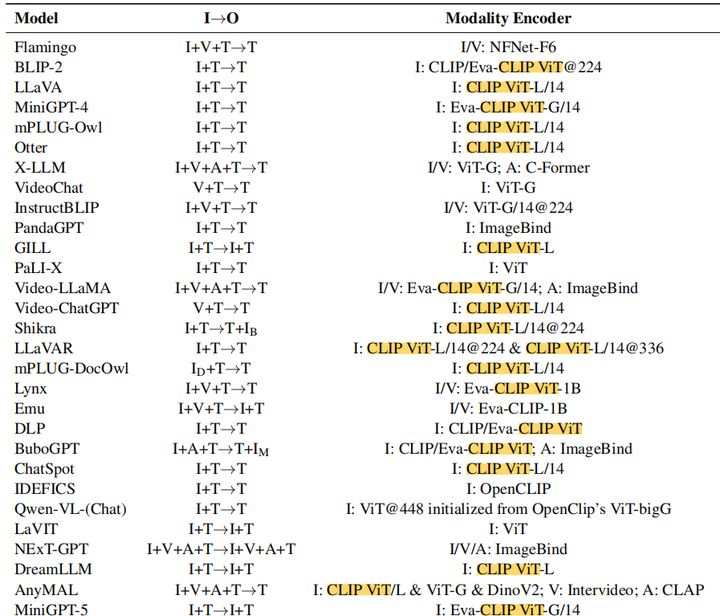
关于更多CLIP论文的解读可以点击下面链接进行阅读：
刘一手：AI多模态基础架构：CLIP—文本图像迁移模型的新高度

二、音频编码器
音频编码器处理声音数据，将音频信号转换成可以被模型分析的形式。这通常包括将音频波形转换成频域表示，如使用傅里叶变换或梅尔频谱倒谱系数（MFCCs）等。 音频编码器可以帮助模型识别语音、音乐或其他声音特征。在多模态模型中，主流的音频编码器包括Whisper、CLAP等

2.1 Whisper
Whisper是 OpenAI于 2022 年09月开放的一个超大规模的语音识别预训练模型，它使用端到端的方式进行多语言的预训练，在开放域的英语ASR （语音识别）能力上已经实现了与人类相对的水平。它在语音识别领域的贡献几乎等同于 ChatGPT对自然语言处理领域的贡献。在 Whisper 公布前，ASR 的研究主要是以Wav2vec2 模型（传统编码器）及其变体组成。但是，Whisper 发现这些基于 Wav2vec2 模型在预训练过程中只能得到一个音频编码器，虽然它可以提取非常高质量的声学编码表示。但是，缺少一个相同质量的解码器。也就是说，在下游的ASR任务中，研究人员需要自行搭建一个解码器。而解码器的质量会在最终 ASR 任务的性能产生很大的波动。同时，基于 Wav2vec2 微调的 ASR 模型在其微调领域的数据集上可能实现与人类相当或者超越人类的性能，但是在其他数据集上往往表现得很差，不够泛化。

PS：语音识别ASR通常包括下面流程：输入——编码——解码——输出
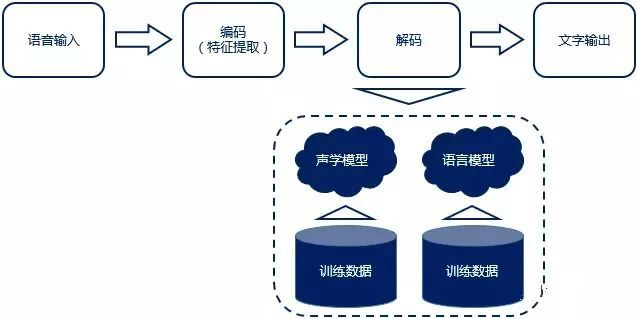

为了提高 ASR 系统的泛化性，无需额外定制解码器，做到开放域的“开箱即用”，OpenAI 的研究人员提出了 Whisper模型。与 Wav2vec2不同，Whisper 又回到了编码器-解码器的结构。但是，它将预训练的语音-文本对从之前的上千小时扩充到了 68 万小时，在超大规模且超高质量的语音-文本对数据的加持下，Whisper模型大大提升了 ASR 模型的泛化能力。同时，由于这些数据集是多语言的，使得 whisper 可以实现对各大主流语言的语音转录。

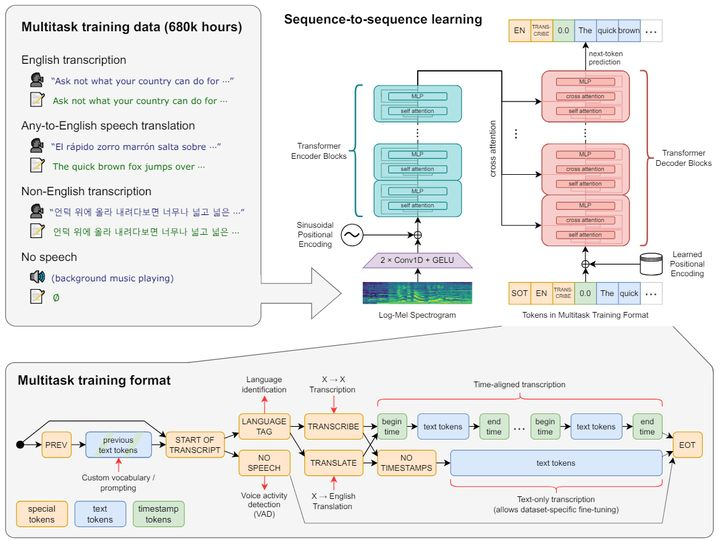

上图展示了 Whisper 的预训练网络框架(摘自 OpenAI研究报告)。从模型结构上来看，Whisper 使用标准的 Transfomer 编码器-解码器架构对模型进行训练。每条语音数据输入长度为 30 秒，通过 25ms 的汉明窗和 10ms 的步移，在 16000 的采样帧率下，转化为 3000 帧长，80维度的对数梅尔频谱图。并使用两层1维的卷积神经网络和 GELU 激活函数对原始对数梅尔频谱图进行初始的特征提取。每条文本会通过特殊设计的多任务训练格式化模块转化为对应的输入序列，它是 Whisper 一个核心部分，它通过自定义的配置流程为每个文本样本加入多样化的 Prompt，使得 Wishper 模型可以在以6种组合方式实现4个不同任务的训练，包括：

通过文本的语言完成口语识别任务；

通过是否存在人声完成语音活性检测；

在语音和文本都是同一种语言时，会进行2个任务：一是发声时长的预测，二是正常的序列到序列生成；

在语音和文本不是同一种语言时(可能语言是中文，预训练的数据是英文)，也会进行2个任务，一是发声时长的预测，二是机器翻译。

这种多任务联合预训练的方式是对原始数据的充分利用，让 Whisper 模型在多个任务中更好地理解数据中的语义关联。相较于 Wav2vec2 只能获得一个高质量的语音编码器，Whisper 的预训练直接提供了一个端到端的 ASR 系统。并且由于多任务训练格式化模块提供的 Prompt学习，它还可以很好的适配到各种语音领域子任务上。

2.2 CLAP
CLAP（Contrastive Language-Audio Pretraining）是在2023年提出的一种基于对比学习的预训练方法，旨在通过结合音频数据和相应的自然语言描述来学习音频的表示。这种方法的核心思想是利用对比学习范式，将音频和文本映射到一个共享的潜在空间中，并通过训练使得相关的音频-文本对在该空间中更接近，而不相关的对更远离。简单来说，CLAP是参考了CLIP的思路，将图像-文本对迁移至音频-文本对，并完成音频数据预训练的工作。

下面是CLAP的模型结构：
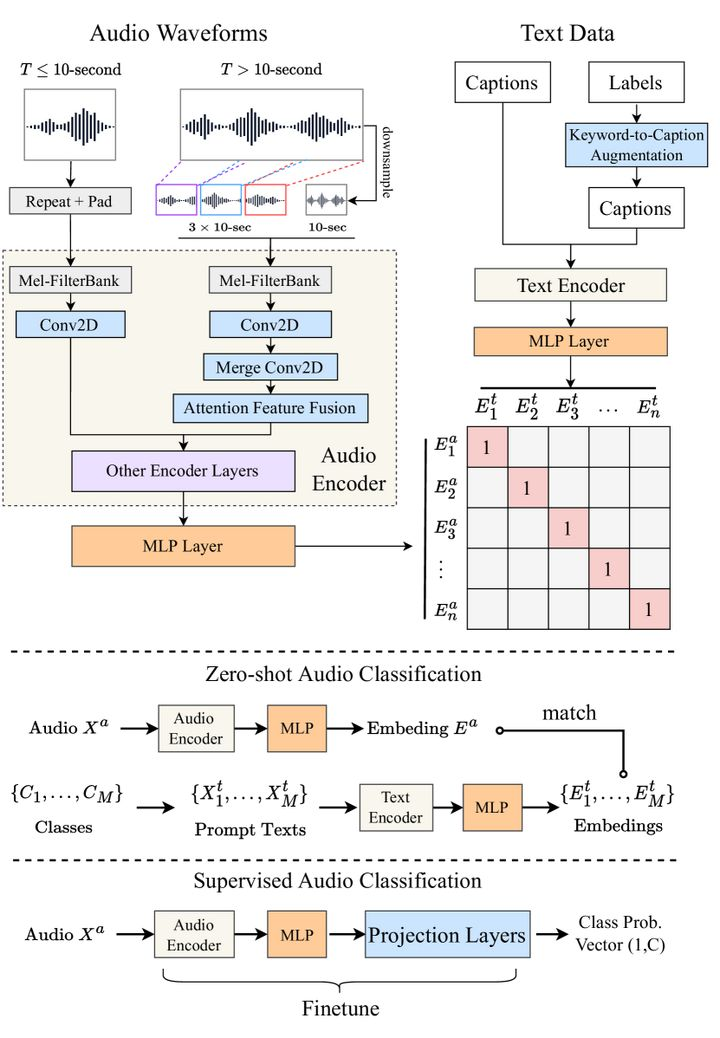

可以看出，CLAP包括下面几个部分：

（1）音频和文本编码器：模型包含两个编码器，分别独立处理音频数据和文本数据。音频编码器使用PANN（一个基于CNN的音频分类模型，具有 7 个下采样 CNN 块和 7 个上采样块）和HTSAT（一个基于Transformer的模型，具有4组swin-transformer模块）模型，文本编码器选择了CLIP transformer、BERT和RoBERTa。

（2）特征融合：为了处理不同长度的音频，模型采用了特征融合机制。对于短于固定长度（如10秒）的音频，模型重复并填充零值（Repeat+Pad）；对于长于固定长度的音频，则采用全局信息和随机采样的局部信息（Downsample）结合的方式。

（3）关键词到标题增强：使用预训练的语言模型T5，基于AudioSet数据集的标签或关键词生成描述性标题，并进行去偏见处理。

（4）对比学习：模型采用对比学习范式进行训练，通过最小化正样本对之间的距离和最大化负样本对之间的距离来学习音频和文本的共享表示。这里“距离”一般使用余弦相似度，与CLIP类似。

（5）下游任务：在推理阶段，模型可以应用于文本到音频检索、零样本音频分类和监督音频分类等任务。

下游任务：文本到音频检索、零样本音频分类和监督音频分类任务的工作流程：

① 文本到音频检索 (Text-to-Audio Retrieval)

目标：给定一段文本描述，找到与之最匹配的音频样本。

音频嵌入：使用预训练的音频编码器处理目标音频，得到音频的嵌入表示。

文本嵌入：使用预训练的文本编码器处理文本描述，得到文本的嵌入表示。

相似性计算：通过计算文本嵌入和音频嵌入之间的相似性（如余弦相似度），找到与文本描述最匹配的音频样本。

② 零样本音频分类 (Zero-Shot Audio Classification)

目标：对未见过的音频类别进行分类，不使用特定于类别的标注数据。

类别描述：为每个音频类别创建一个或多个文本提示（prompts），例如，“这是[类别名称]的声音”。

音频嵌入：使用音频编码器得到待分类音频的嵌入表示。

类别匹配：通过计算音频嵌入与各个类别描述文本嵌入之间的相似性，确定音频最可能属于的类别。

③ 监督音频分类 (Supervised Audio Classification)

目标：对音频样本进行分类，使用标注了类别的数据进行训练和评估。

训练数据：使用标注了类别的音频样本进行模型的微调训练。

音频嵌入：使用微调后的音频编码器得到待分类音频的嵌入表示。

分类器：通常在音频编码器的输出上添加一个或多个全连接层，形成分类器头（classifier head），用于将音频嵌入映射到特定类别的得分。

损失函数：使用如交叉熵损失函数来训练分类器，使其能够准确预测音频的类别。

（多么熟悉的流程）

在多模态的架构中，通常使用Whisper模型的编码器或者CLAP模型的编码器作为输入的音频模态的编码器，并将其拓展到多模态QA任务上。

三、视频编码器
视频编码器更复杂，因为它需要同时处理图像和时间序列数据。视频由一系列图像帧组成，编码器不仅需要提取每一帧的视觉特征，还需要理解这些帧随时间的变化，例如运动信息。在多模态架构中，视频编码器可能会使用类似于图像编码器的技术来处理每一帧，同时还会使用额外的技术来处理帧与帧之间的关系，如ViViT 、VideoPrism。

3.1 VideoPrism
VideoPrism 是一个通用视频编码器，2024年2月由谷歌提出，它能够处理多种视频理解任务，包括视频分类、视频文本检索、视频描述问答及其他下游任务。

VideoPrism 通过在包含 3600 万个高质量视频-字幕对和 5.82 亿个带有噪声并行文本（例如，自动语音识别（ASR）转录）的视频片段的异构语料库上进行预训练来实现这一目标。该预训练方法通过全局-局部蒸馏语义视频嵌入和一种令牌洗牌方案来改进掩蔽自编码，使 VideoPrism 能够主要关注视频模态，同时利用与视频相关的任何文本。
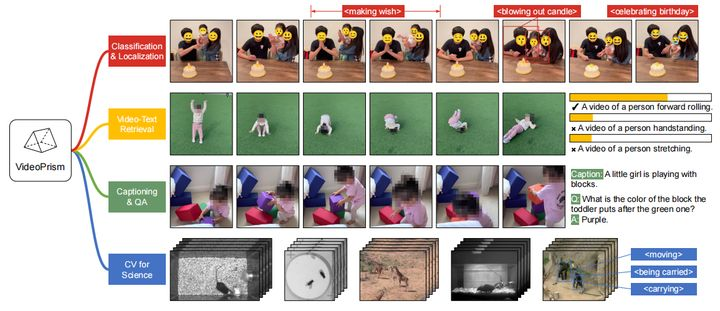

下图展示了VideoPrism的模型结构：
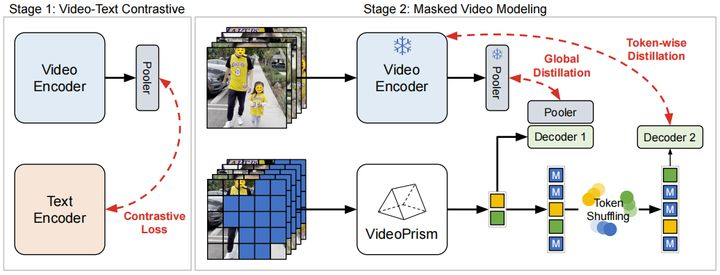

可以看出，VideoPrism一共包括两个阶段，每个阶段都有其特定的目标和训练方法：

（1）第一阶段：视频-文本对比训练 (Video-Text Contrastive Training)

这一阶段的目标是利用视频-文本对来训练视频编码器和文本编码器，使它们能够在一个共享的潜在空间中对齐语义表示。具体步骤包括：

视频和文本编码器初始化：使用标准的 Transformer 架构作为文本编码器，并初始化空间编码器。

对比损失函数：通过最小化视频和文本对的相似性得分的对称交叉熵损失来训练模型。鼓励模型将正样本（相关联的视频和文本）嵌入到接近的位置，而将负样本（不相关联的视频和文本）嵌入到较远的位置。

特征聚合：在计算损失之前，使用多头注意力池化器（如 MAP 层）来聚合视频编码器的输出特征。

预训练数据：使用包括高质量视频-字幕对和带有噪声的并行文本的视频数据进行训练。

（2）第二阶段：掩蔽视频建模 (Masked Video Modeling)

第二阶段专注于从仅视频数据中学习外观和运动信息，同时保留第一阶段学习到的语义知识。这一阶段的关键点包括：

掩蔽自编码：采用掩蔽自编码方法，其中随机选择一部分输入视频的令牌（patches）进行掩盖，然后训练模型以预测这些被掩盖的令牌。

令牌洗牌：为了防止解码器简单地复制未掩盖的令牌，编码器的输出令牌在送入解码器之前会进行随机洗牌，增加了模型学习视频内容的难度。

全局-局部蒸馏：为了缓解在两阶段预训练中可能发生的灾难性遗忘问题，引入全局蒸馏损失，让第二阶段的模型学习从第一阶段的模型中蒸馏出完整的视频全局嵌入。

改进的掩蔽视频建模：在第二阶段，模型在所有仅视频数据上继续训练，使用改进的掩蔽视频建模方法，包括上述的令牌洗牌和全局-局部蒸馏损失。

VideoPrism 的架构包含以下几个关键组件：

空间编码器 (Spatial Encoder)：它处理输入视频的单个帧，类似于图像编码器。空间编码器使用多层的卷积神经网络来提取视频中每帧的空间特征。

时间编码器 (Temporal Encoder)：在空间编码器的基础上，时间编码器进一步建模视频帧之间的时间关系。涉及到跨帧的特征交互，以捕捉视频中的运动信息。

全局平均池化层 (Global Average Pooling Layer)：在 ViViT 的基础上，VideoPrism 移除了全局平均池化层，这样做使得模型能够保持输出令牌序列中的空间和时间维度，有助于需要细粒度特征的下游任务，如时空动作定位。
